In [1]:
import wandb
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

import gym
import argparse
import numpy as np
from collections import deque
import random

tf.compat.v1.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


# Train an agent

In [19]:
tf.keras.backend.set_floatx('float64')
wandb.init(name='DQN', project="deep-rl-tf2")

class Args:
    gamma = 0.99
    lr = 0.005
    batch_size = 32
    eps = 1.0
    eps_decay = 0.9998
    eps_min = 0.01
    
args = Args()

class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)
    
    def put(self, state, action, reward, next_state, done):
        self.buffer.append([state, action, reward, next_state, done])
    
    def sample(self, size=None):
        if size is None:
            size = args.batch_size
        sample = random.sample(self.buffer, size)
        states, actions, rewards, next_states, done = map(np.asarray, zip(*sample))
        states = np.array(states).reshape(size, -1)
        next_states = np.array(next_states).reshape(size, -1)
        return states, actions, rewards, next_states, done
    
    def size(self):
        return len(self.buffer)
    

class ActionStateModel:
    def __init__(self, state_dim, aciton_dim):
        self.state_dim  = state_dim
        self.action_dim = aciton_dim
        self.epsilon = args.eps
        
        self.model = self.create_model()
    
    def create_model(self):
        model = tf.keras.Sequential([
            Input((self.state_dim,)),
            Dense(32, activation='relu'),
            Dense(16, activation='relu'),
            Dense(self.action_dim)
        ])
        model.compile(loss='mse', optimizer=Adam(args.lr))
        return model
    
    def predict(self, state):
        return self.model.predict(state)
    
    def get_action(self, state, decrease_eps):
        state = np.reshape(state, [1, self.state_dim])
        if decrease_eps:
            self.epsilon *= args.eps_decay
        self.epsilon = max(self.epsilon, args.eps_min)
#         print(self.epsilon)
        q_value = self.predict(state)[0]
        if np.random.random() < self.epsilon:
            return random.randint(0, self.action_dim-1)
        return np.argmax(q_value)

    def train(self, states, targets):
        self.model.fit(states, targets, epochs=1, verbose=0)
    

class Agent:
    def __init__(self, env):
        self.env = env
        self.state_dim = self.env.observation_space.shape[0]
        self.action_dim = self.env.action_space.n

        self.model = ActionStateModel(self.state_dim, self.action_dim)
        self.target_model = ActionStateModel(self.state_dim, self.action_dim)
        self.target_update()

        self.buffer = ReplayBuffer()
        self.rewards = []

    def target_update(self):
        weights = self.model.model.get_weights()
        self.target_model.model.set_weights(weights)
    
    def replay(self):
        for _ in range(10):
            states, actions, rewards, next_states, done = self.buffer.sample()
            targets = self.target_model.predict(states)
            next_q_values = self.target_model.predict(next_states).max(axis=1)
            targets[range(args.batch_size), actions] = rewards + (1-done) * next_q_values * args.gamma
            self.model.train(states, targets)
    
    def train(self, max_episodes=1000):
        init_steps = 500
        for ep in range(max_episodes):
            done, total_reward = False, 0
            state = self.env.reset()
            while not done:
                action = self.model.get_action(state, decrease_eps=self.buffer.size() >= init_steps)
                next_state, reward, done, _ = self.env.step(action)
                self.buffer.put(state, action, reward*0.01, next_state, done)
                total_reward += reward
                state = next_state
            if self.buffer.size() >= init_steps:
                self.replay()
            if ep % 2 == 0:
                self.target_update()
            self.rewards.append(total_reward)
#             print('EP{} EpisodeReward={}'.format(ep, total_reward))
            if np.mean(self.rewards[-100:]) > 190:
                print('Mean reward for last 100 episodes exceeds 180')
                break
            wandb.log({'Reward': total_reward})
    
    def act(self, state):
        return np.argmax(self.model.predict(np.reshape(state, [1, self.state_dim]))[0])
        

    

wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [20]:
env = gym.make('CartPole-v0')
agent = Agent(env)
agent.train(max_episodes=300)

Mean reward for last 100 episodes exceeds 180


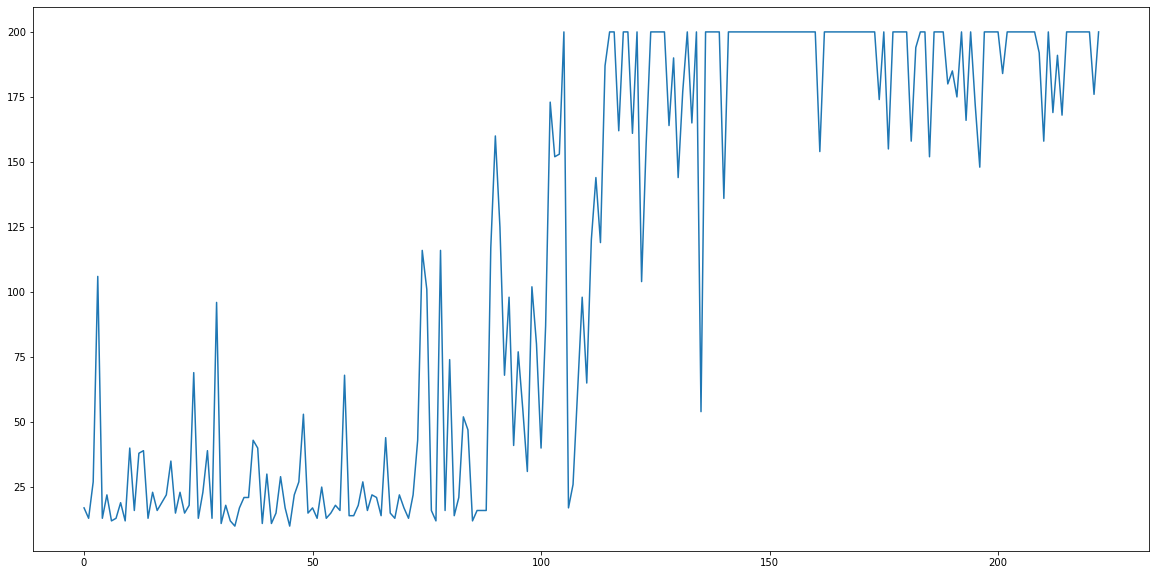

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 10))
plt.plot(agent.rewards)

In [22]:
agent.model.epsilon

0.01

In [23]:
agent.buffer.size()

10000

In [24]:
import pandas as pd

agent.model.model.save('cartpole_dqn_mlp_0')

states, actions, rewards, next_states, done = agent.buffer.sample(3000)
states = np.asarray(states)
states_df = pd.DataFrame(data=states, index=None, columns=["Cart Position", "Cart Velocity", "Pole Angle", "Pole Angular Velocity"])
states_df.to_csv('states.csv', index=False)

In [25]:
env = gym.make('CartPole-v0')
agent = Agent(env)
agent.model = tf.keras.models.load_model("cartpole_dqn_mlp_0")

NameError: name 'agent' is not defined

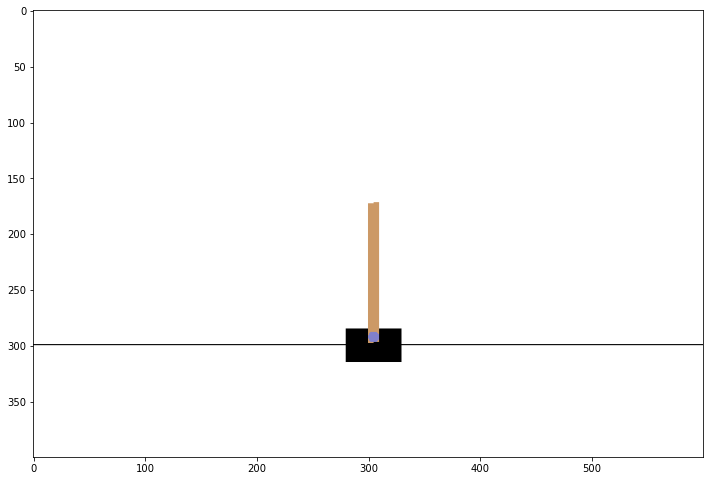

In [1]:
import gym
from IPython import display
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

env = gym.make('CartPole-v0')
state = env.reset()
plt.figure(figsize=(12, 12))
img = plt.imshow(env.render(mode='rgb_array')) # only call this once
for _ in range(1):
    done, total_reward = False, 0
    state = env.reset()
    while not done:
        img.set_data(env.render(mode='rgb_array')) # just update the data
        display.display(plt.gcf())
        display.clear_output(wait=True)
        action = agent.act(state)
        state, reward, done, info = env.step(action)
        total_reward += reward
    print(total_reward)
env.close()